In [7]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from enum import IntEnum
from abc import ABC, abstractmethod
import random
import math

In [3]:
class Action(IntEnum):
    UP = 3
    DOWN = 1
    RIGHT = 0
    LEFT = 2

In [4]:
COLORS = {
    "red": '#FF000000',
    "green": '#00FF00',
    "blue": '#0000FF',
    "purple": '#A020F0',
    "yellow": '#FFFF00',
    "grey": '#808080',
}

SHAPES = {
    "triangle": Triangle,
    "square": Square,
    "circle": Circle,
    "rectangle": Rectangle
}

# Map of object type to integers
OBJECT_TO_IDX = {
    "empty": 0,
    "agent": 1,
    "object":2,
    "goal": 8,
}

IDX_TO_OBJECT = {v: k for k, v in OBJECT_TO_IDX.items()}
HEX_TO_COLOR = {v: k for k, v in COLORS.items()}

# Map of agent direction indices to vectors
DIR_TO_VEC = [
    # Right (positive X)
    np.array((1, 0)),
    # Down (positive Y)
    np.array((0, 1)),
    # Left (negative X)
    np.array((-1, 0)),
    # Up (negative Y)
    np.array((0, -1)),
]

WIDTH = 200
HEIGHT = 200
GRID_SIZE = 20
DEBUG = True
DIR = './'

In [27]:
from PIL import Image, ImageDraw
import numpy as np
from enum import IntEnum
from abc import ABC, abstractmethod
import random
import math
import time
import uuid
import json

class Action(IntEnum):
    UP = 3
    DOWN = 1
    RIGHT = 0
    LEFT = 2


COLORS = {
    "red": '#FF000000',
    "green": '#00FF00',
    "blue": '#0000FF',
    "purple": '#A020F0',
    "yellow": '#FFFF00',
    "grey": '#808080',
}

# Map of object type to integers
OBJECT_TO_IDX = {
    "empty": 0,
    "agent": 1,
    "object":2,
    "goal": 8,
}

IDX_TO_OBJECT = {v: k for k, v in OBJECT_TO_IDX.items()}
HEX_TO_COLOR = {v: k for k, v in COLORS.items()}

SHAPES_TO_IDX = {
    'triangle' : 0,
    'circle' : 1,
    'square' : 2,
    'rectangle' : 3
}

# Map of agent direction indices to vectors
DIR_TO_VEC = [
    # Right (positive X)
    np.array((1, 0)),
    # Down (positive Y)
    np.array((0, 1)),
    # Left (negative X)
    np.array((-1, 0)),
    # Up (negative Y)
    np.array((0, -1)),
]

WIDTH = 200
HEIGHT = 200
GRID_SIZE = 20
DEBUG = True
DIR = './'

class Shape:
    '''
        Attributes
        ----------
        distance_from_cooridinates : int
             How far the center should be from the points
        color : str
            A hex representation of the color that triangle should be
        fill : str
            Whether the object should be filled or not

        Methods
        -------
        init(self, size=int, color=str, fill=Bool, sound=None)
            Initializes the class
        draw(self, world=ImageDraw, x=int, y=int)
            Draws the triangle to the given Image at the x,y coordinates
        get_coordinates(self, x=int, y=int)
            Given a centerpoint, calculates the points of the triangle
    '''

    def __init__(self, size, color, fill=False, initial_loc=(-1, -1)):
        self.distance_from_coordinate = (size / 2)
        self.color = color
        self.fill = fill
        self.row, self.col = initial_loc

    @abstractmethod
    def draw(self, world, x, y):
        pass

    @abstractmethod
    def get_coordinates(self, x, y):
        pass


class Triangle(Shape):
    def __init__(self, size, color, fill=False, initial_loc=(-1, -1)):
        Shape.__init__(self, size, color, fill, initial_loc)
        self.shape = "triangle"

    # Draw a triangle around this point
    def draw(self, world, x, y):
        ImageDraw.ink = self.color
        bottom_left, bottom_right, top = self.get_coordinates(x, y)
        world.polygon([bottom_left, bottom_right, top], self.color, outline="black")

    def get_coordinates(self, x, y):
        x1 = x - self.distance_from_coordinate
        x2 = x + self.distance_from_coordinate
        x3 = x
        y1 = y + self.distance_from_coordinate
        y2 = y + self.distance_from_coordinate
        y3 = y - self.distance_from_coordinate

        return (x1, y1), (x2, y2), (x3, y3)


class Rectangle(Shape):
    def __init__(self, size, color, fill=False, initial_loc=(-1, -1)):
        Shape.__init__(self, size, color, fill, initial_loc)
        self.shape = "rectangle"

    # Draw a triangle around this point
    def draw(self, world, x, y):
        ImageDraw.ink = self.color
        top_left, bottom_right = self.get_coordinates(x, y)

        world.rectangle([top_left, bottom_right], self.color, outline="black")

    def get_coordinates(self, x, y):
        height = self.distance_from_coordinate / 2
        x1, y1 = x - self.distance_from_coordinate, y - height
        x2, y2 = x + self.distance_from_coordinate, y + height
        return (x1, y1), (x2, y2)


class Square(Shape):
    def __init__(self, size, color, fill=False, initial_loc=(-1, -1)):
        Shape.__init__(self, size, color, fill, initial_loc)
        self.shape = "square"

    def draw(self, world, x, y):
        ImageDraw.ink = self.color
        top_left, bottom_right = self.get_coordinates(x, y)
        world.rectangle([top_left, bottom_right], self.color, outline="black")

    def get_coordinates(self, x, y):
        x1, y1 = x - self.distance_from_coordinate, y - self.distance_from_coordinate
        x2, y2 = x + self.distance_from_coordinate, y + self.distance_from_coordinate
        return (x1, y1), (x2, y2)


class Circle(Shape):
    def __init__(self, size, color, fill=False, initial_loc=(-1, -1)):
        Shape.__init__(self, size, color, fill, initial_loc)
        self.shape = "circle"

    def draw(self, world, x, y):
        ImageDraw.ink = self.color
        bottom_left, top_right = self.get_coordinates(x, y)
        world.ellipse([bottom_left, top_right], fill=self.color, outline="black")

    def get_coordinates(self, x, y):
        x1, y1 = x - self.distance_from_coordinate, y - self.distance_from_coordinate
        x2, y2 = x + self.distance_from_coordinate, y + self.distance_from_coordinate
        return (x1, y1), (x2, y2)


class Goal:
    def __init__(self, world, starting_loc=(-1, -1), shape=Square, color='#FFFF00'):
        self.world = world
        self.row, self.col = starting_loc
        self.shape = shape(GRID_SIZE / 2, color)

    def __str__(self):
        location = "Location: (" + str(self.row) + "," + str(self.col) + ") "
        obj = self.get_name()
        return location + obj

    def get_name(self):
        return HEX_TO_COLOR[self.shape.color] + " " + self.shape.shape

    def update_loc(self, row, col):
        self.row = row
        self.col = col

    def draw(self, world, x, y):
        self.shape.draw(world, x, y)

    def update_world_reference(self, world):
        self.world = world

SHAPES = {
    "triangle": Triangle,
    "square": Square,
    "circle": Circle,
    "rectangle": Rectangle
}


class Agent:
    def __init__(self, world, starting_loc=(-1, -1), shape=Triangle, color='#FFFF00'):
        self.world = world
        self.row, self.col = starting_loc
        self.shape = shape(GRID_SIZE / 2, color)

    def __str__(self):
        location = "Location: (" + str(self.row) + "," + str(self.col) + ") "
        obj = self.get_name()
        return location + obj

    def get_name(self):
        return HEX_TO_COLOR[self.shape.color] + " " + self.shape.shape

    def update_loc(self, row, col):
        self.row = row
        self.col = col

    def draw(self, world, x, y):
        self.shape.draw(world, x, y)

    # 0 - Right, 1 - Down, 2 - Left, 3 - Up
    def move(self, direction):
        x_change, y_change = DIR_TO_VEC[direction]
        new_row, new_col = self.row + x_change, self.col + y_change

        if self.world.space_can_be_visited(new_row, new_col):
            self.update_loc(new_row, new_col)
            self.world.update_agent_pos(new_row, new_col)

    def update_world_reference(self, world):
        self.world = world

class GridWorld:
    """
            This acts as our 2d world. Will handle logic of keeping objects in place

    """
    def __init__(self, size, background_color='#FFFFFF', agent = None, goal = None, max_obstacles = 3):
        self.image = None
        self.pencil = None
        self.size = size
        self.x_offset = int(abs((WIDTH - size * GRID_SIZE) / 2))
        self.y_offset = int(abs((HEIGHT - size * GRID_SIZE) / 2))

        self.world = np.empty(shape=(size, size), dtype=object)

        if agent is None:
            self.agent = Agent(self)
        else:
            self.agent = agent
            self.agent.update_world_reference(self)

        if goal is None:
            self.goal = Goal(self)
        else:
            self.goal = goal
            self.goal.update_world_reference(self)


        max_obstacles = min(max_obstacles, math.floor((self.size ** 2) / 3))
        self.total_obstacles = random.randint(0, max_obstacles)
        self.objective = "move the " + self.agent.get_name() + " to the " + self.goal.get_name()

        self.__setup_initial_locations()

        if DEBUG:
            print(self.agent)
            print(self.goal)

    def __setup_initial_locations(self):
        # Makes min objects 1, so goal can be placed
        total_objects = self.total_obstacles
        agent_row, agent_col = self.__find_free_space('agent')
        self.agent.update_loc(agent_row, agent_col)

        goal_row, goal_col = self.__find_free_space('goal')
        self.goal.update_loc(goal_row, goal_col)

        while total_objects > 0:
            row, col = self.__find_free_space('object')
            if row == -1 and col == -1:
                break
            else:
                total_objects -= 1


    def display_image(self):
        self.draw()
        plt.imshow(self.image)

    def save_image(self):
        self.draw()
        uuid_string = uuid.uuid4().hex.upper()[0:6]
        filename = time.strftime("%Y%m%d-%H%M%S")
        self.image.save(DIR + uuid_string + "-" + filename + '.png')

    # Draws the individual grids, as well as the objects contained in the underlying array
    def draw(self):
        self.refresh_canvas()
        step_size = GRID_SIZE

        y_start = self.y_offset
        y_end = self.y_offset + (step_size * self.size)
        x_start = self.x_offset
        x_end = self.x_offset + (step_size * self.size)

        for x in range(y_start, y_end + 1, step_size):
            line = ((x, y_start), (x, y_end))
            self.pencil.line(line, fill=128)

        for y in range(x_start, x_end + 1, step_size):
            line = ((x_start, y), (x_end, y))
            self.pencil.line(line, fill=128)
        self.draw_objects()

        return step_size

    # Draws the objects in the associated array
    def draw_objects(self):
        for col in range(0, self.size):
            for row in range(0, self.size):
                world_object = self.world[row, col]

                if world_object is not None:
                    if isinstance(world_object, Agent):
                        x, y = self.get_coordinates_from_array_loc(row, col)
                        self.agent.draw(self.pencil, x, y)
                    elif isinstance(world_object, Goal):
                        x, y = self.get_coordinates_from_array_loc(row, col)
                        self.goal.draw(self.pencil, x, y)
                    else:
                        x, y = self.get_coordinates_from_array_loc(row, col)
                        world_object.draw(self.pencil, x, y)

    def get_coordinates_from_array_loc(self, row, col):
        centroid = GRID_SIZE / 2
        x = centroid + self.x_offset + (GRID_SIZE * row)
        y = centroid + self.y_offset + (GRID_SIZE * col)
        return x, y

    def __find_free_space(self, object_to_place):
        print("Placing " + object_to_place)
        count = 0
        row, col = None, None
        while row is None and col is None or self.world[row, col] is not None:
            if count > self.size:
                return -1, -1
            row = random.randint(0, self.world.shape[0] - 1)
            col = random.randint(0, self.world.shape[1] - 1)
            count += 1

        if object_to_place == 'object':
            shape, color = get_random_unique_shape_and_color(self)
            self.world[row, col] = SHAPES[shape](GRID_SIZE / 2, color)
        elif object_to_place == 'agent':
            self.world[row, col] = self.agent
        elif object_to_place == 'goal':
            self.world[row, col] = self.goal

        return row, col

    def space_can_be_visited(self, row, col):
        if (row < self.size and col < self.size) and (row >= 0 and col >= 0) \
                and (self.world[row, col] is None or isinstance(self.world[row, col], Goal)):
            return True
        else:
            return False

    def update_agent_pos(self, row, col):
        for row in range(0, len(self.world)):
            for col in range(0, len(self.world[row])):
                if isinstance(self.world[row, col], Agent):
                    self.world[row, col] = None
        self.world[self.agent.row, self.agent.col] = self.agent

    def refresh_canvas(self):
        if self.pencil is not None:
            del self.image
            del self.pencil
        image = Image.new(mode='RGB', size=(WIDTH, HEIGHT), color=(255, 255, 255, 0))
        self.pencil = ImageDraw.Draw(image)
        self.image = image


def get_random_shape():
    return random.sample(list(SHAPES), 1)[0]


def get_random_color():
    return random.sample(list(COLORS), 1)[0]


def get_random_unique_shape_and_color(world):
    agent_shape = world.agent.shape.shape
    agent_color = world.agent.shape.color
    goal_shape = world.goal.shape.shape
    goal_color = world.goal.shape.color

    random_shape = None
    random_color = None
    # Keep going until you have a unique shape/color that is not an agent or goal
    while (random_shape is None and random_color is None) or \
            (random_shape == agent_shape and random_color == agent_color) or \
            (random_shape == goal_shape and random_color == goal_color):
        random_shape = get_random_shape()
        random_color = get_random_color()

    return random_shape, random_color

Placing agent
Placing goal
Location: (7,3) yellow triangle
Location: (0,7) yellow square


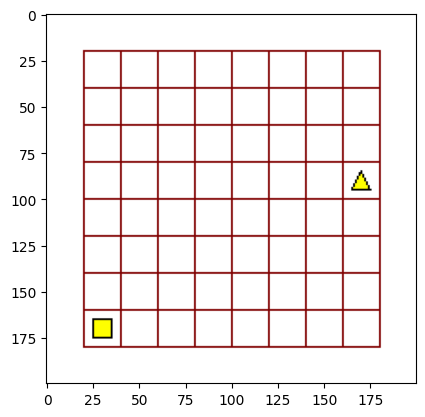

In [51]:
world2 = GridWorld(8, max_obstacles=0)
world2.display_image()

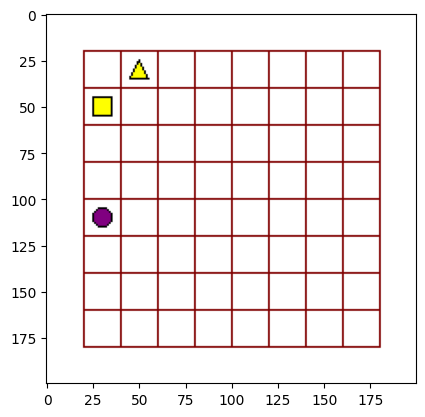

In [25]:
world2.agent.move(Action.RIGHT)
world2.display_image()

In [97]:
world2.agent.move(Action.DOWN)
world2.draw()
world2.image.show()
print(world2.world)


0 1
3 4
[[<__main__.Rectangle object at 0x123049450> None
 [<__main__.Square object at 0x1269c8310> None None None]
 [None None <__main__.Square object at 0x1269c85e0> None]
 [None None None <__main__.Agent object at 0x123f49ae0>]]


4
